# Model baselines

This notebook is devoted to find simple models to state that data is somehow feasible to use for regression. Let's read the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pydotplus
from IPython.display import Image

from widedeep.utils import *
from widedeep.data.display import *
from widedeep.data.data_ops import *

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

def mean_error(pred, truth):
    return np.mean(np.abs(pred - truth))
    
def rmse(pred, truth):
    return np.sqrt(np.mean(np.square(pred - truth)))

data = pd.read_csv(AIRBNB_FINAL)

## Modeling prices

Let's use a subset of the data to build some models (i.e. use instances from 5 cities) and check simple approaches to predict lodging prices. We also decide to remove neighbourhood information in this step.

In [2]:
cities = data['area'].unique().tolist()
data_subset = data[data['area'].isin(cities[:5])]
data_subset = data_subset.drop(['subarea'], 1)

print('Using %d instances and %d columns' % (data_subset.shape[0], data_subset.shape[1]))

Using 36490 instances and 69 columns


### Numerical version the data

Now we will generate an additional version of the data so it can be handled as a fully dense numerical data set. To do so, we will convert each categorical column into dummy binary features.

In [3]:
excl = ['listing_url', 'last_scraped', 'id', 'scrape_id', 'picture_url']
# Convert into boolean
num_data = convert_to_dummy(data_subset, excluded_columns=excl)
num_data = convert_boolean(num_data, func=float)

2017-02-14 13:39:38,700 - data - INFO - Converting area into dummy column ...
2017-02-14 13:39:38,741 - data - INFO - Converting bed_type into dummy column ...
2017-02-14 13:39:38,785 - data - INFO - Converting cancellation_policy into dummy column ...
2017-02-14 13:39:38,824 - data - INFO - Converting country into dummy column ...
2017-02-14 13:39:38,863 - data - INFO - Converting property_type into dummy column ...
2017-02-14 13:39:38,969 - data - INFO - Converting review_scores_accuracy into dummy column ...
2017-02-14 13:39:39,005 - data - INFO - Converting review_scores_checkin into dummy column ...
2017-02-14 13:39:39,041 - data - INFO - Converting review_scores_cleanliness into dummy column ...
2017-02-14 13:39:39,080 - data - INFO - Converting review_scores_communication into dummy column ...
2017-02-14 13:39:39,120 - data - INFO - Converting review_scores_location into dummy column ...
2017-02-14 13:39:39,158 - data - INFO - Converting review_scores_rating into dummy column ..

## Validation set and scaling

Let's separate data between training and validation. We are also scaling data so it lies around 0 (mean 0) and the standard deviation of each column is 1.

In [8]:
# X and Y as inputs of models
excluded_cols = ['id', 'picture_url', 'scrape_id', 'listing_url', 'last_scraped', 'final_price']
#features = ['accommodates', 'beds', 'bedrooms', 'bathrooms']
features = [f for f in num_data.columns.values if f not in excluded_cols]
X, Y = num_data[features], num_data['final_price']

# Split data into training and test
train_inds, test_inds = split_data(len(X), 0.80)
X_train, Y_train = X.iloc[train_inds], Y.iloc[train_inds]
X_test, Y_test = X.iloc[test_inds], Y.iloc[test_inds]

# Finally, let's generate a scaled version of the data that has mean 0 and std of 1
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

Let's also visualize characteristics of the input target:

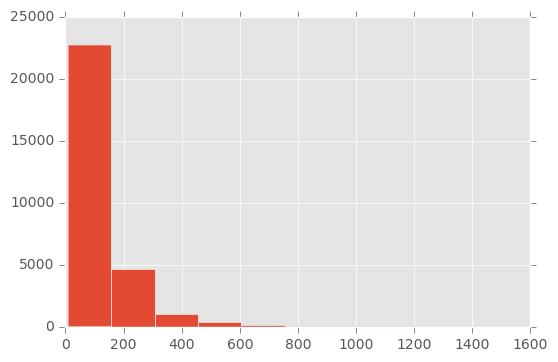

In [6]:
num_data.iloc[train_inds]['final_price'].hist()

## Linear regression

We can try to approximate the price using the simplest model: a Linear Regression. This model predicts the output by performing a dot product between the input features (numeric) and the learnt weights, which minimize the distance between the predicted value and the true value.

In [9]:
# Try linear model and see coefficients
lr = LinearRegression(fit_intercept=True, normalize=False, n_jobs=2)
lr = lr.fit(X_train_s, Y_train)
coeffs = zip(features, lr.coef_)
for (n, c) in coeffs:
    print('Coefficient for %s is %f' % (n, c))

Coefficient for accommodates is 31.701923
Coefficient for bathrooms is 22.280167
Coefficient for bedrooms is 17.897399
Coefficient for beds is -3.231722
Coefficient for cleaning_fee is 23.374890
Coefficient for guests_included is -3.123410
Coefficient for host_has_profile_pic is 0.124892
Coefficient for host_identity_verified is -0.974202
Coefficient for host_is_superhost is -0.026863
Coefficient for host_verifications is -1.120019
Coefficient for instant_bookable is -1.284597
Coefficient for minimum_nights is -5.738826
Coefficient for recent_review is -4.714969
Coefficient for reviews_per_month is -1.081843
Coefficient for security_deposit is 9.859597
Coefficient for suitable for events is 2.961666
Coefficient for dog(s) is 0.812632
Coefficient for safety card is 0.675819
Coefficient for pets allowed is 0.014608
Coefficient for breakfast is 0.349043
Coefficient for doorman is 0.274730
Coefficient for pets live on this property is -1.487148
Coefficient for wheelchair accessible is 1.22

Histogram of test predictions for linear regression


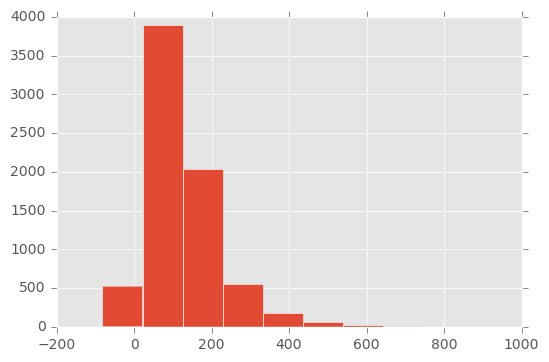

In [10]:
print('Histogram of test predictions for linear regression')
plt.hist(lr.predict(X_test_s))
plt.show()

In [11]:
test_error = np.mean(np.abs(lr.predict(X_test_s) - Y_test))
print('Mean error on test is %f' % test_error)

Mean error on test is 44.761175


In [12]:
lr_train_pred = lr.predict(X_train_s)
lr_train_pred[0:10]

array([  73.52386811,   79.75091889,  203.92230561,  105.57904389,
         99.53216889,   80.50336029,  167.28168061,   46.43011811,
         53.39154389,  126.29779389])

In [13]:
print('Mean prediction for linear regression %f' % lr_train_pred.mean())
print('Std prediction for linear regression %f' % lr_train_pred.std())

Mean prediction for linear regression 126.051521
Std prediction for linear regression 98.001297


## Non-linear models

We know that a problem with such complexity will rarely be linear. Let's see if the results improve once we use a non-linear model such as a Multi-layer Perceptron (MLP).

In [35]:
print('Mean price in dataset is %f' % num_data['final_price'].mean())
print('Mean std in dataset is %f' % num_data['final_price'].std())

Mean price in dataset is 112.998671
Mean std in dataset is 83.652593


In [46]:
def log_step(model, data_inp, data_gt, step, prefix):
    predicted = model.predict(data_inp)
    err = mean_error(predicted, data_gt)
    rmse_err = rmse(predicted, data_gt)
    print('[Iteration %d, Loss %f] %s error is %f and rmse is %f' % (step, mlp.loss_, prefix, err, rmse_err))
    
# Train iteratively
num_steps = 100
mlp = MLPRegressor(activation='tanh', 
                   # solver='lbfgs',
                   solver='adam',
                   alpha=1e-5,
                   learning_rate_init=0.01,
                   hidden_layer_sizes=(25, 25, 25),
                   warm_start=False, 
                   max_iter=1)


for s in range(num_steps):
    mlp.fit(X_train_s, Y_train)
    if s % 10 == 0:
        log_step(mlp, X_train_s, Y_train, s, 'training')
        log_step(mlp, X_test_s, Y_test, s, 'testing')

# Extract stats from the predicted training instances
predicted = mlp.predict(X_train_s)
print('Mean of predicted data is %f' % predicted.mean())
print('Std of predicted data is %f' % predicted.std())

[Iteration 0, Loss 7578.539248] training error is 74.620170 and rmse is 110.043772
[Iteration 0, Loss 7578.539248] testing error is 75.597434 and rmse is 111.605608
[Iteration 10, Loss 7647.812934] training error is 75.409767 and rmse is 110.751268
[Iteration 10, Loss 7647.812934] testing error is 76.393381 and rmse is 112.312155
[Iteration 20, Loss 7621.447260] training error is 75.007892 and rmse is 110.392297
[Iteration 20, Loss 7621.447260] testing error is 75.988528 and rmse is 111.953670
[Iteration 30, Loss 7550.835262] training error is 74.559429 and rmse is 109.989044
[Iteration 30, Loss 7550.835262] testing error is 75.536190 and rmse is 111.550952
[Iteration 40, Loss 7551.228125] training error is 74.533065 and rmse is 109.965293
[Iteration 40, Loss 7551.228125] testing error is 75.509575 and rmse is 111.527233
[Iteration 50, Loss 7582.521076] training error is 74.790858 and rmse is 110.197262
[Iteration 50, Loss 7582.521076] testing error is 75.769557 and rmse is 111.758900


In [39]:
predicted[0:10]

array([ 41.50573514,  41.49941569,  41.50651601,  41.50660978,
        41.4949519 ,  41.50991408,  41.50559181,  41.50788011,
        41.51010889,  41.50376761])

Histogram of training data


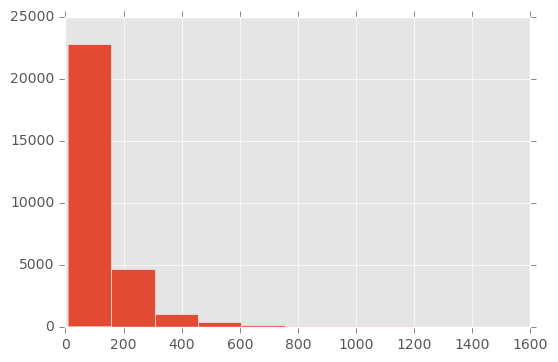

In [43]:
print('Histogram of training data')
plt.hist(Y_train)
plt.show()

Histogram of predicted data


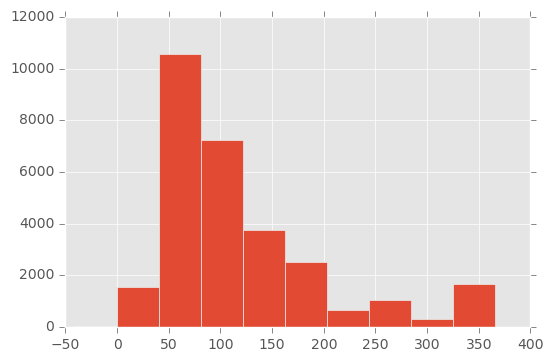

In [44]:
print('Histogram of predicted data')
plt.hist(predicted)
plt.show()

In [57]:
test_error = np.mean(np.abs(mlp.predict(X_test_s) - Y_test))
test_error_med = np.median(np.abs(mlp.predict(X_test_s) - Y_test))
print('Mean error on test is %f. Median error is %f' % (test_error, test_error_med))

Mean error on test is 76.710651. Median error is 60.055970


## Decision trees

Let's try using decision trees.

In [13]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train_s, Y_train)

In [14]:
predicted_tree_train = clf.predict(X_train_s)
predicted_tree_test = clf.predict(X_test_s)
print('Mean error on train is %f' % (mean_error(predicted_tree_train, Y_train)))

print('Mean error on test is %f' % (mean_error(predicted_tree_test, Y_test)))

Mean error on train is 0.101162
Mean error on test is 55.669241


In [16]:
# Create picture for the computed tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names='final_price',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

KeyboardInterrupt: 